In [1]:
# ruff: noqa: E402 F401
"""
https://www.kaggle.com/c/dogs-vs-cats/overview
"""
import os
from pathlib import Path

iskaggle = os.getenv("KAGGLE_KERNEL_RUN_TYPE")

# If on kaggle, install packages
if iskaggle:
    os.system("pip install fastai")

import pandas as pd
from fastai.callback.schedule import fine_tune
from fastai.data.block import DataBlock, RegressionBlock
from fastai.data.transforms import ColReader, ColSplitter
from fastai.metrics import accuracy, mae, mse
from fastai.text.data import TextBlock
from fastai.text.learner import AWD_LSTM, TextLearner, text_classifier_learner

# TODO Save model
# model_file = Path("model.pkl")

!wget -c "https://raw.githubusercontent.com/BurnySc2/deep-learning-examples/82179fab48595b0730ca00502fde0eecef92a7d3/text_sentiment_classification/CMU-MOSEI.csv" -O CMU-MOSEI.csv

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


--2024-01-16 09:19:36--  https://raw.githubusercontent.com/BurnySc2/deep-learning-examples/82179fab48595b0730ca00502fde0eecef92a7d3/text_sentiment_classification/CMU-MOSEI.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3512157 (3.3M) [text/plain]
Saving to: 'CMU-MOSEI.csv'

CMU-MOSEI.csv       100%[===================>]   3.35M  13.2MB/s    in 0.3s    

2024-01-16 09:19:38 (13.2 MB/s) - 'CMU-MOSEI.csv' saved [3512157/3512157]



In [2]:
# Uoad csv file with text and labels
def get_train_valid_items(my_path: Path) -> pd.DataFrame:
    for file in sorted(my_path.iterdir()):
        if file.suffix != ".csv":
            continue
        # Only read one file for now
        df = pd.read_csv(file)
        # Turn text to lowercase
        df["text"] = df["text"].apply(lambda text: text.lower())
        # Create one new columns
        df["is_valid"] = df["mode"].apply(lambda mode: mode == "valid")
        return df


# TODO Why does this not work
def get_x(item: pd.DataFrame) -> str:
    return item["text"]


def get_y(item: pd.DataFrame) -> str:
    return item["label"]


# TODO use https://docs.fast.ai/text.data.html#textblock.from_df in different file
# TODO use https://docs.fast.ai/text.data.html#textdataloaders.from_df in different file
# TODO use https://docs.fast.ai/text.data.html#textdataloaders.from_csv in different file
# TODO with tabular learner?

# Create a DataBlock for text data
dblock = DataBlock(
    blocks=(
        # Input is a pandas dataframe
        # TODO Use custom text encoder/transformer
        TextBlock.from_df(
            text_cols="text",
            seq_len=72,
        ),
        # Output block has a numeric value
        RegressionBlock(),
    ),
    # Load data
    get_items=get_train_valid_items,
    # Input data is in the column 'text'
    get_x=ColReader("text"),
    # Output value is in the column 'label'
    get_y=ColReader("label"),
    # TODO Use custom functions instead
    # get_x=get_x,
    # get_y=get_y,
    # Split in training and validation data
    splitter=ColSplitter(col="is_valid"),
)

# Create dataloader
dls = dblock.dataloaders(source=Path("."))

In [3]:
# Show preview
dls.show_batch(max_n=3)

,text,text_
0,xxbos i went over the four main product types along with her down payments and seller 's concession in this video we 're going to take a look into the conventional loan for a single - family home so if you see here we have a minimum down payment of three percent now that is if you are a first time xxunk or have not had a property interest in a home in the past three years you can qualify for that three percent otherwise you 're looking at a five percent down payment at minimum and then we have a three percent seller 's concession now that 's if you 're putting anywhere from three percent to ten percent down if you put ten percent to twenty percent down the seller 's concession goes up to six percent and any more than twenty percent it goes all the way,0.3333333432674408
1,"xxbos hi there , today i have a very special announcement namely , i 'll be attending the xxunk usa convention this year , it 's going to take place at manhattan college in xxunk , ny from june 19 to june 22 , 2015 and i 'm super , super excited it 's extra special because it 's the first convention that i 'll be attending outside of europe so i look forward to seeing a lot of people that i have n't met before perhaps you , too and something special too about this convention is that i will be a special guest so i was invited which is a huge , huge honor for me and i 'll be teaching lots of workshops and i 'll also be joined by xxunk xxunk xxunk as the other special guest and he 's such an awesome artist i really",2.6666667461395264
2,"xxbos let me tell you a story about my grandmother every time that i used to date a new boyfriend she would ask his name and then she would go like "" and what part of the city does he live in ? "" that was her way of asking if my boyfriend was white she was an out and out racist so i know the face of xxunk governor reston is telling me i do n't have the xxunk to be president and he means that literally it 's offensive it 's offensive to me it 's offensive to every woman out there who he is asking the votes for tonight i am here stating that governor reston is a sexist but you know what",-2.3333332538604736


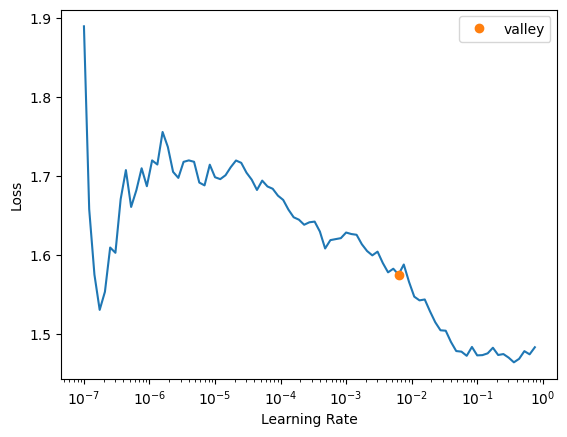

In [4]:
# Create a text learner
# TODO Other metrics https://docs.fast.ai/metrics.html#regression
# TODO Use other pre-trained models
learn: TextLearner = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=[mse, mae, accuracy])

# Find a good learning rate
suggested_learn_rate = learn.lr_find().valley

In [11]:
epochs = 4

# Choose a learning rate based on the plot
# lr = 1e-2
lr = suggested_learn_rate
print(f"Chosen learn rate: {lr}")

# Fine-tune the model
learn.fine_tune(epochs, lr)

Chosen learn rate: 0.0063095735386013985


epoch,train_loss,valid_loss,mse,mae,accuracy,time
0,0.591320,0.606484,0.606484,0.588299,0.231427,00:15


epoch,train_loss,valid_loss,mse,mae,accuracy,time
0,0.586542,0.592391,0.592391,0.586908,0.231427,00:19
1,0.557573,0.588038,0.588038,0.575030,0.231427,00:18
2,0.490736,0.590454,0.590454,0.576310,0.231427,00:18
3,0.432618,0.592822,0.592822,0.580616,0.231427,00:18


In [12]:
# Show model structure
print(learn.model)

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8408, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8408, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0-2): 3 x RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)
      )
      (1): LinBnDrop(
        (0): Bat

In [13]:
# Predict
learn.predict("I really liked that movie!")

((2.2125186920166016,), tensor([2.2125]), tensor([2.2125]))

In [14]:
learn.predict("I hated that movie!")

((-1.4073935747146606,), tensor([-1.4074]), tensor([-1.4074]))

In [15]:
learn.predict("That movie was disgusting!")

((-1.9799373149871826,), tensor([-1.9799]), tensor([-1.9799]))